In [1]:
import numpy as np
import seaborn as sns
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

import seaborn as sns

sns.set_context("talk")

### Метод Гаусса

In [2]:
def gauss(A):
    m = len(A)
    assert all([len(row) == m + 1 for row in A[1:]]), "Некорректная матрица! Строки разной длины!"
    n = m + 1
    
    for k in range(m):
        pivots = [abs(A[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k
        
        assert A[i_max][k] != 0, "Матрица вырождена!"
        A[k], A[i_max] = A[i_max], A[k]
        
        for i in range(k + 1, m):
            f = A[i][k] / A[k][k]
            for j in range(k + 1, n):
                A[i][j] -= A[k][j] * f
            A[i][k] = 0
    
    # Решаем уравнение Ax=b для верхне-треугольной матрицы A         
    x = list()
    for i in range(m - 1, -1, -1):
        x.insert(0, A[i][m] / A[i][i])
        for k in range(i - 1, -1, -1):
            A[k][m] -= A[k][i] * x[0]
    return x

### Метод Зейделя

In [3]:
def seidel(A, b, optimal, discrepancy=False, eps=1e-8, x_0=None, max_iteration=100, verbose=False):
    n = len(A)
    x_1 = list()
    
    iterator = 0
    x = [.0 for i in range(n)] if x_0 is None else x_0
    
    converge = False
    while not converge:
        x_new = np.copy(x)
        for i in range(n):
            s1 = sum(A[i][j] * x_new[j] for j in range(i))
            s2 = sum(A[i][j] * x[j] for j in range(i + 1, n))
            x_new[i] = (b[i] - s1 - s2) / A[i][i]
        
        # оптимальный критерий останова
        if optimal and len(x_1) != 0:
            converge = norm_R**iterator / (1 - norm_R) * sqrt(sum((x_1[i]) ** 2 for i in range(n))) <= eps
            if converge and verbose:
                print(f'Оптимальный критерий останова сработал на {iterator+1} шаге')
        
        elif discrepancy and len(x_1) != 0:
            converge = sqrt(sum([x**2 for x in error(A, x_new, b)])) <= eps
            if converge and verbose:
                print(f'Стандартный критерий останова по невязке сработал на {iterator+1} шаге')
        
        else:
            converge = sqrt(sum((x_new[i] - x[i]) ** 2 for i in range(n))) <= eps
            if converge and verbose:
                print(f'Стандартный критерий останова по изменению значения за итерацию сработал на {iterator+1} шаге')
        
        x = x_new
        
        if iterator == 0:
            x_1 = x_new
        
        iterator += 1
        if iterator > max_iteration:
            raise ValueError("Не сходится за отведенное число итераций")

    return x

### Функция вычисления невязки

In [4]:
def error(A, x, b):
    y = [x[0] for x in (np.matrix(A) * np.matrix(x).transpose()).tolist()]
    return [abs(b[i]-y[i]) for i in range(len(b))]

In [5]:
# составляем тестовую расширенную матрицу А
n = 99
a = [1] * n
b = [10] * n
c = [1] * n
p = [1] * (n+1)
f = [1+x for x in range(n+1)]
test_1 = [[b[0], c[0]] + [0]*(n-1) + [f[0]]]
for i in range(n-1):
    temp = [0]*(n+1)
    temp[i:i+2] = a[i+1], b[i+1], c[i+1]
    temp[-1] = f[i+1]
    test_1.append(temp)
test_1.append(p+[f[n]])

# матрица А и столбец ответов b
A = [row[:-1] for row in test_1]
b = [row[-1] for row in test_1]

print(np.matrix(test_1))

[[ 10   1   0 ...   0   0   1]
 [  1  10   1 ...   0   0   2]
 [  0   1  10 ...   0   0   3]
 ...
 [  0   0   0 ...   1   0  98]
 [  0   0   0 ...  10   1  99]
 [  1   1   1 ...   1   1 100]]


### Описание матрицы

In [6]:
# вычисляем min и max собственные значения матрицы А
eigenvalues = np.linalg.eig(A)[0]
lambda_max = max(eigenvalues)
lambda_min = min(eigenvalues)
# вычисляем число обусловленности матрицы А
cond = np.linalg.cond(A)

print('lambda_min(A) = %f\nlambda_max(A) = %f\nчисл. обусловленности = ||A||*||A^(-1)|| = %f'\
        %(lambda_min, lambda_max, cond))

lambda_min(A) = 0.899889
lambda_max(A) = 12.007561
числ. обусловленности = ||A||*||A^(-1)|| = 22.458342


In [7]:
D = np.diag(np.diag(A)) 
L = np.tril(A, k = -1) 
U = np.triu(A, k = 1)

R = - (np.matrix(np.linalg.inv(L+D)) * U)
norm_R = max([sum([abs(x_i) for x_i in x]) for x in np.transpose(R).tolist()])

In [8]:
# вычисляем min и max собственные значения матрицы R
eigenvalues = np.linalg.eig(R)[0]
abs_lambda_max = max([max(eigenvalues), -min(eigenvalues)])
print('max(|lambda(R)|) = %0.3f\nnorm(R) = %0.3e' %(abs_lambda_max.real, norm_R))

max(|lambda(R)|) = 0.111
norm(R) = 2.020e-01


$\|B\| =$ 2.020e-01$< 1$

$\Rightarrow$ выполнено достаточное условие сходимости итерационного метода, эквивалентного методу Зейделя

**Оптимальный критерий останова:** $\|x^*-x_k\| \le \frac{\| B \|^k}{1- \|B\|} \| x_1 - x_0\| = \frac{\| B \|^k}{1- \|B\|} \| x_1\|$

### Тест функций на пункте (a)

In [9]:
# применяем метод Гаусса
gauss_res = gauss(test_1)

In [10]:
# применяем метод Зейделя
#@title Параметры метода Зейделя

max_iteration = 100 #@param {type:"slider", min:10, max:100, step:5}
eps = 1e-8 #@param {type:"number"}
optimal = True #@param {type:"boolean"}
discrepancy = False #@param {type:"boolean"}

seidel_res = seidel(A, b, optimal, discrepancy=discrepancy, max_iteration=max_iteration, eps=eps, verbose=True)

print(f'MAE(невязка) = {np.mean([abs(x) for x in error(A, seidel_res, b)])}')

Оптимальный критерий останова сработал на 17 шаге
MAE(невязка) = 4.269917752708352e-15


**Выводы:** 
1. Применение оптимального критерия останова позволяет добиться сходимости на 17 шаге с невязкой *3.98e-15*

2. Применение стандартного критерия для $\varepsilon < $ *1e-15* позволяет методу сойтись за меньшее число итераций при меньшей точности невязки

### Инфографика 

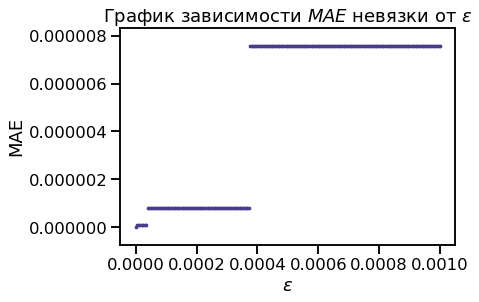

In [11]:
xs = np.linspace(1e-10, 0.001, 200)
ys = [np.mean(error(A, seidel(A, b, False, max_iteration=max_iteration, eps=x), b)) for x in xs]
plt.title("График зависимости $MAE$ невязки от $\epsilon$")
plt.xlabel('$\epsilon$')
plt.ylabel('MAE')
plt.ylim((-0.1*max(ys), 1.1*max(ys)))
plt.xlim((-0.00005, 0.00105))
plt.scatter(xs, ys, color='darkslateblue', s=5);

**Комментарий:** сходимость имеет выраженный ступенчатый вид

### Mетод SVD

$A \, x = b$ -- СЛАУ

$A = U\, S\, V^T$ -- сингулярное разложение матрицы $A$

$x = V \, diag(\frac{1}{s_{ii}}) \, U^T\, b$ -- решение СЛАУ

In [12]:
def diag_frac(S):
    for i in range(len(S)):
        S[i][i] = 1.0/S[i][i]
    return S

In [13]:
U, S, V_T = np.linalg.svd(A, full_matrices=False)

In [14]:
svd_res = [x[0] for x in (np.transpose(V_T) @ diag_frac(np.diag(S)) @ np.transpose(U) @ np.transpose(np.matrix(b))).tolist()]
print('MAE(м.SVD) = %.4e' %np.mean(error(A, svd_res, b)))

MAE(м.SVD) = 4.3073e-12


### Метод верхней релаксации

In [15]:
def SOR(A, b, eps, max_iteration, verbose=False):
    D = np.diag(np.diag(A)) 
    L = np.tril(A, k = -1) 
    U = np.triu(A, k = 1)
    
    Q = np.linalg.inv(D + w * L)
    K = np.dot(Q,((1.0 - w) * D - w * U))
    F = w*np.dot(Q, b)
    
    x = np.zeros_like(b)
    for j in range(1, max_iteration):
        x_new = np.dot(K, x) + F
        converge = sqrt(sum((x_new[i] - x[i]) ** 2 for i in range(n))) <= eps
        if converge:
            if verbose:
                print(f'Потребовалось {j} итераций')
            return x_new
        x = x_new
    raise ValueError("Не сходится за отведенное число итераций")

In [16]:
def optimal_w(A):
    D = np.diag(np.diag(A)) 
    L = np.tril(A, k = -1) 
    U = np.triu(A, k = 1)
    
    R = - (np.matrix(np.linalg.inv(L+D)) * U)
    spect_radius = max(map(abs, np.linalg.eig(R)[0]))
    w_opt = 2 / (1 + sqrt(1-spect_radius**2))
    return w_opt

In [17]:
w = 1 #@param {type:"slider", min:0, max:2, step:0.05}
max_iteration = 100 #@param {type:"slider", min:10, max:100, step:5}
eps = 1e-13 #@param {type:"number"}
w_optimal = True #@param {type:"boolean"}

if w_optimal:
    w = optimal_w(A) 

sor_res = SOR(A, b, eps, max_iteration, verbose=True)
print(f'MAE(невязка) = {np.mean([abs(x) for x in error(A, sor_res, b)])}')

Потребовалось 17 итераций
MAE(невязка) = 5.970779426434092e-15


**Вывод:** применение оптимального веса $w$ позволяет добиться *MAE(невязки)* $\approx$*6.68e-15* на *17* шаге

### Результаты 
_Оценим невязку используя, используя_ ***MAE*** _(средняя абсолютная ошибка) к вектору истинных ответов $b$ и ответам $b_0$, полученным с помощью выбранного метода._

In [18]:
gaus_mae = np.mean([abs(x) for x in error(A, gauss_res, b)])
seid_mae = np.mean([abs(x) for x in error(A, seidel(A, b, True, max_iteration=max_iteration, eps=eps, verbose=False), b)])
svd_mae = np.mean([abs(x) for x in error(A, svd_res, b)])
sor_mae = np.mean([abs(x) for x in error(A, sor_res, b)])
print('MAE(м.Гаусса) = %.4e\nMAE(м.Зейделя) = %0.4e, iters = 19\nMAE(м.SVD) = %0.4e\nMAE(м.SOR) = %0.4e, iters = 17' %(gaus_mae, seid_mae, svd_mae, sor_mae))

MAE(м.Гаусса) = 5.3779e-15
MAE(м.Зейделя) = 3.1308e-15, iters = 19
MAE(м.SVD) = 4.3073e-12
MAE(м.SOR) = 5.9708e-15, iters = 17


In [19]:
#### ДОДЕЛАТЬ ГРАФИЧЕСКУЮ ЗАВИСИМОСТЬ КРИТЕРИЕВ ОСТАНОВА -- ЧИСЛО ВЕРНЫХ ЗНАКОВ ПОСЛЕ ЗАПЯТОЙ ДЛЯ РАЗНЫХ КРИТЕРИЕВ ОСТАНОВА (ОПТИМАЛЬНЫЙ, ПО ДЕЛЬТЕ, ПО НЕВЯЗКЕ)
#### ПОСТОРИТЬ ГРАФИК
#### ОБЩЕЕ ИСЛЕДОВАНИЕ НЕВЯЗКИ

### Анализ взаимосвязей критериев останова

* оптимальный: $\frac{\| B \|^k}{1- \|B\|} \| x_1 - x_0\| < \varepsilon$
* по изменению значения за итерацию: $\| \Delta x_{k+1} \|_E = \sqrt{\sum \limits_{j=1}^n (x_{k+1}[j]-x_k[j])^2} < \varepsilon$
* по невязке: $\| f_k - f\|_E = \sqrt{\sum \limits_{j=1}^n (f_{k}[j]-f[j])^2} < \varepsilon$, где $f_k = A \cdot x_k$ - невязка на $k-$ом шаге

Рассмотрим число верных цифр в результате работы каждого из этих методов при различных значения параметра $\varepsilon$. Для интерпретации результата рассматриваются среднее значение числа верных цифр после запятой в векторе ответов $x$ и среднеквадратическое отклонение этой величины.

In [20]:
# вычисление числа верных цифр после запятой
def right_digits(x, true_x):
    max_by_element = [np.max([0]+[i for i in range(1, 16) if abs(x[j]-true_x[j])<10**(-i)]) for j in range(len(x))]
    return np.mean(max_by_element), np.std(max_by_element)

In [21]:
true_x = np.linalg.solve(A, b)

In [22]:
epss = [10**(-i) for i in np.linspace(0, 12, 120)]
# optimal 
optimal, discrepancy = True, False
opt_coincides = list()
for eps in epss:
    res = seidel(A, b, optimal, discrepancy=discrepancy,\
                    max_iteration=100, eps=eps, verbose=False)
    opt_coincides.append(right_digits(res, true_x))

# delta
optimal, discrepancy = False, False
delta_coincides = list()
for eps in epss:
    res = seidel(A, b, optimal, discrepancy=discrepancy,\
                    max_iteration=100, eps=eps, verbose=False)
    delta_coincides.append(right_digits(res, true_x))

# discrepancy
coin_epss = epss[:]
optimal, discrepancy = False, True
coin_coincides = list()
for eps in coin_epss:
    res = seidel(A, b, optimal, discrepancy=discrepancy,\
                    max_iteration=100, eps=eps, verbose=False)
    coin_coincides.append(right_digits(res, true_x))

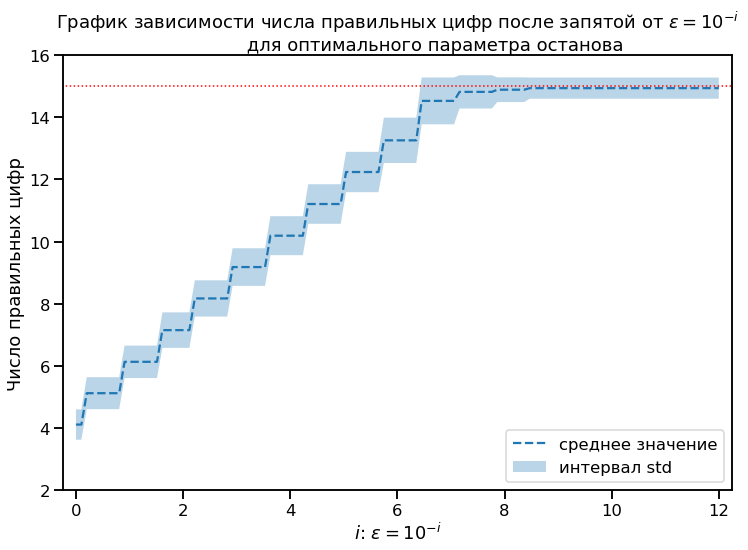

In [23]:
xs = np.linspace(0, 12, 120)
ys = [x[0] for x in opt_coincides]
top_border = [x[0] + x[1] for x in opt_coincides]
low_border = list(reversed([x[0] - x[1] for x in opt_coincides]))

plt.figure(figsize=(12, 8))
plt.ylim((2, 16))
plt.xlim((-0.25, 12.25))
plt.xlabel('$i$: $\epsilon=10^{-i}$')
plt.ylabel('Число правильных цифр')
plt.title('''График зависимости числа правильных цифр после запятой от $\epsilon=10^{-i}$
             для оптимального параметра останова''')
plt.plot(xs, ys, linestyle='--', label='среднее значение');
plt.plot([-1, 13], [15, 15], ':', c='red', lw=1.5)
plt.fill(list(xs)+list(reversed(xs)), top_border+low_border, alpha=0.3, label='интервал std');
plt.legend(loc=4);

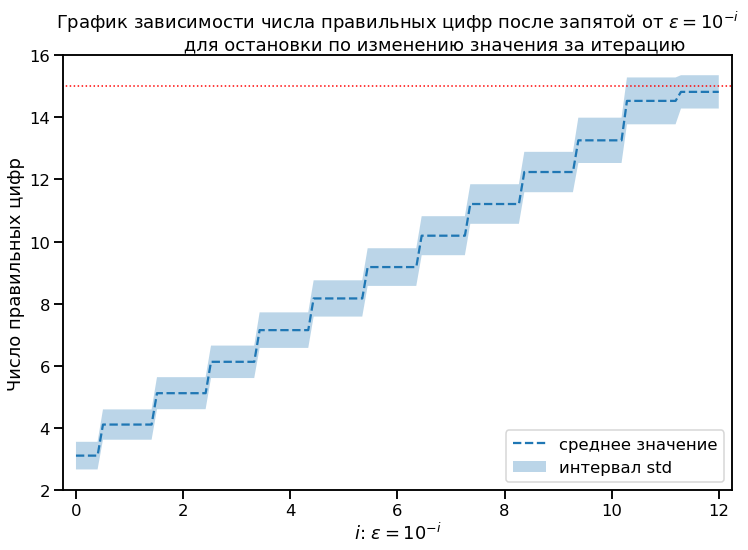

In [24]:
xs = np.linspace(0, 12, 120)
ys = [x[0] for x in delta_coincides]
top_border = [x[0] + x[1] for x in delta_coincides]
low_border = list(reversed([x[0] - x[1] for x in delta_coincides]))

plt.figure(figsize=(12, 8))
plt.ylim((2, 16))
plt.xlim((-0.25, 12.25))
plt.xlabel('$i$: $\epsilon=10^{-i}$')
plt.ylabel('Число правильных цифр')
plt.title('''График зависимости числа правильных цифр после запятой от $\epsilon=10^{-i}$
             для остановки по изменению значения за итерацию''')
plt.plot(xs, ys, linestyle='--', label='среднее значение');
plt.plot([-1, 13], [15, 15], ':', c='red', lw=1.5)
plt.fill(list(xs)+list(reversed(xs)), top_border+low_border, alpha=0.3, label='интервал std');
plt.legend();

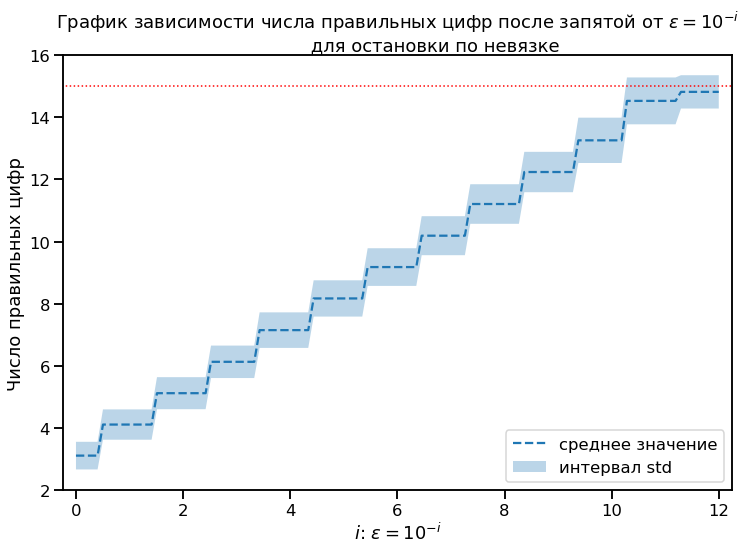

In [25]:
xs = np.linspace(0, 12, 120)
ys = [x[0] for x in coin_coincides]
top_border = [x[0] + x[1] for x in coin_coincides]
low_border = list(reversed([x[0] - x[1] for x in coin_coincides]))

plt.figure(figsize=(12, 8))
plt.ylim((2, 16))
plt.xlim((-0.25, 12.25))
plt.xlabel('$i$: $\epsilon=10^{-i}$')
plt.ylabel('Число правильных цифр')
plt.title('''График зависимости числа правильных цифр после запятой от $\epsilon=10^{-i}$
             для остановки по невязке''')
plt.plot(xs, ys, linestyle='--', label='среднее значение');
plt.plot([-1, 13], [15, 15], ':', c='red', lw=1.5)
plt.fill(list(xs)+list(reversed(xs)), top_border+low_border, alpha=0.3, label='интервал std');
plt.legend();

In [26]:
eps = 1e-5
print('epsilon = 1e-5')
_ = seidel(A, b, True, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=True,
                    max_iteration=100, eps=eps, verbose=True)

epsilon = 1e-5
Оптимальный критерий останова сработал на 13 шаге
Стандартный критерий останова по изменению значения за итерацию сработал на 9 шаге
Стандартный критерий останова по невязке сработал на 9 шаге


In [27]:
eps = 1e-10
print('epsilon = 1e-10')
_ = seidel(A, b, True, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=True,
                    max_iteration=100, eps=eps, verbose=True)

epsilon = 1e-10
Оптимальный критерий останова сработал на 20 шаге
Стандартный критерий останова по изменению значения за итерацию сработал на 14 шаге
Стандартный критерий останова по невязке сработал на 14 шаге


In [28]:
eps = 1e-12
print('epsilon = 1e-5')
_ = seidel(A, b, True, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=False,
                    max_iteration=100, eps=eps, verbose=True)
_ = seidel(A, b, False, discrepancy=True,
                    max_iteration=100, eps=eps, verbose=True)

epsilon = 1e-5
Оптимальный критерий останова сработал на 23 шаге
Стандартный критерий останова по изменению значения за итерацию сработал на 16 шаге
Стандартный критерий останова по невязке сработал на 16 шаге


Не смотря на полученный результат второй и третий критерии не эквивалентны и совпадают лишь в рамках этой задачи. Что связано с устройством матрицы и установлена путем рассмотрения пошаговых значений. 